# Baseline

We establish a strong baseline in this notebook with:
- Local Outlier Factor (LOF),
- One-Class SVM,
- Isolation Forest,
- Autoencoder.

We chose the MNIST dataset for this benchmark, excluding the digit *9* from the training data: *9* shall be considered the anomalous data.

In [1]:
import os

import numpy as np
np.random.seed(0)
np.set_printoptions(suppress=True)

from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_curve
from sklearn.datasets import fetch_mldata
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import decomposition

import pandas as pd

import time
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
mnist = fetch_mldata('MNIST original', data_home='.', )
mnist.data = mnist.data.astype(np.float32)
mu = np.mean(mnist.data)
std = np.std(mnist.data)
mnist.data = (mnist.data - mu) / std

In [3]:
X_random = np.random.uniform(size=(500, 784))

### 1. MNIST anomaly dataset

In [6]:
nnominal = 4859
nanomalies = 265
fours = mnist.data[mnist.target == 4]
rests = mnist.data[mnist.target != 4]
idx = np.random.choice(range(fours.shape[0]), size=nnominal, replace=False)
fours = fours[idx]
idx = np.random.choice(range(rests.shape[0]), size=nanomalies, replace=False)
rests = rests[idx]
# X_train = np.concatenate([fours[:500], sevens[:10]])
X_train = np.concatenate([fours, rests])
Y_train = np.array([0] * nnominal + [1] * nanomalies)
X_test, Y_test = X_train, Y_train
# X_test = np.concatenate([fours[1000:], sevens[10:]])
# Y_test = np.array([0] * ntest_normal + [1] * 80)

### 7's and full MNIST

Use 50% of training data exlcuding 7 for training and the rest for evaluation.

In [4]:
# X = mnist.data[mnist.target != 7]
# Y = mnist.target[mnist.target != 7]
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)
# X_anomalies_full = mnist.data[mnist.target == 7]

# X_random = np.random.uniform(size=(10000, 784))

Subsample the anomalies.

In [4]:
# rate = .05
# size = np.min((int(rate * X_train.shape[0]), X_anomalies_full.shape[0]))
# idx = np.random.choice(range(X_anomalies_full.shape[0]), size=size, replace=False)
# X_anomalies = X_anomalies_full[idx]

Some helper functions.

In [11]:
def calc_pr(scores, labels, plot=False):
    """
    Given scores and labels, returns the precision, recall, thresholds and
    area under the curve.
    
    Params:
        scores      (1d-numpy array): low scores should represent anomalies.
        labels      (1d-numpy array): same shape as `score`, `1` is for anonaly,
                                      `0` for normal data.
        plot                  (bool): if `True`, plots the precision-recall curve.
    
    Returns:
        precision, recall, thresholds, area under the curve
    """
    if scores.ndim != 1:
        raise ValueError('`scores` has %i dimensions instead of 1.' % scores.ndim)
    if not isinstance(scores, np.ndarray):
        scores = np.array(scores)
    if not isinstance(labels, np.ndarray):
        labels = np.array(labels)
    
    idx = np.argsort(scores)
    ascores = scores[idx]
    alabels = labels[idx]
    tps = np.cumsum(alabels).astype(np.float32)
    fps = np.arange(tps.shape[0]) + 1. - tps
    recall = tps / np.sum(alabels)
    precision = np.divide(tps, tps + fps, out=np.zeros_like(tps), where=(tps + fps)!=0.)
    auc = np.trapz(precision, recall)
    
    if plot:
        plot_pr(precision, recall, auc)
    return precision, recall, ascores, auc


def plot_pr(precision, recall, auc=None):
    plt.plot(recall, precision)
    plt.ylim((0., 1.1))
    plt.xlim((0., 1.1))
    plt.ylabel('precision')
    plt.xlabel('recall');
    plt.title('Precision-Recall curve (AUC = %s)\n' % ('%.3f' % auc if auc else 'N/A'), size=14)
    plt.show

## 1. Isolation Forest

In [6]:
iforest = IsolationForest(contamination=.05, n_estimators=500,n_jobs=-1)
iforest.fit(X_train)
y_pred_test = iforest.decision_function(X_test)
y_pred_random = iforest.decision_function(X_random)

/Users/bmyara/miniconda/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


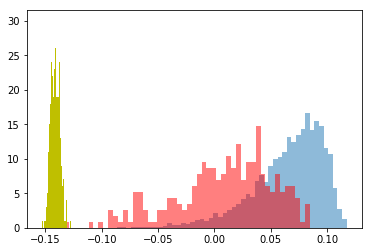

In [8]:
plt.hist(y_pred_test[:nnominal], bins=50, normed=True, alpha=.5)
plt.hist(y_pred_test[nnominal:], bins=50, color='red', normed=True, alpha=.5);
plt.hist(y_pred_random, bins=50, color='y');

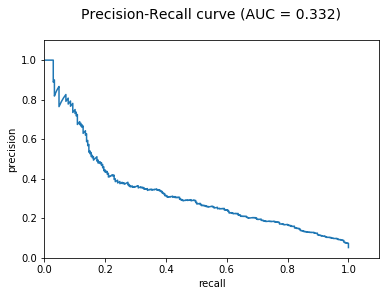

In [9]:
scores = y_pred_test
labels = Y_test
p, r, t, auc = calc_pr(scores, labels)
plot_pr(p, r, auc)

The results are pretty bad. Let's use PCA on the data beforehand.

In [12]:
varE = [.1, .2, .3, .4, .5, .6, .7, .85, .9, .95, .98, .99, .9999999, 1.]
aucs = []
ypredtests = []
for v in varE:
    
    # (1) Dimensionality reduction
    print('*' * 20)
    pca = decomposition.PCA(v) if v != 1. else decomposition.PCA()
    X_train_pca = pca.fit_transform(X_train)
    print(' explained variance = %.2f - n components = %i' % (v, pca.n_components_))
    
    # Isolation Forest
    iforest = IsolationForest(contamination=.0, n_jobs=-1, n_estimators=500)
    iforest.fit(X_train_pca)
    X_test_pca = pca.transform(X_test)
    y_pred_test = iforest.decision_function(X_test_pca)
    scores = y_pred_test
    labels = Y_test
    ypredtests.append(y_pred_test)

    p, r, t, auc = calc_pr(scores, labels)
    aucs.append(auc)
    print('AUC = %.3f' % auc)

y_pred_test = ypredtests[np.argmax(aucs)]
auc = aucs[np.argmax(aucs)]

********************
 explained variance = 0.10 - n components = 1
AUC = 0.043
********************
 explained variance = 0.20 - n components = 2
AUC = 0.040
********************
 explained variance = 0.30 - n components = 4
AUC = 0.042
********************
 explained variance = 0.40 - n components = 6
AUC = 0.042
********************
 explained variance = 0.50 - n components = 9
AUC = 0.080
********************
 explained variance = 0.60 - n components = 13
AUC = 0.083
********************
 explained variance = 0.70 - n components = 22
AUC = 0.282
********************
 explained variance = 0.85 - n components = 52
AUC = 0.554
********************
 explained variance = 0.90 - n components = 79
AUC = 0.608
********************
 explained variance = 0.95 - n components = 139
AUC = 0.569
********************
 explained variance = 0.98 - n components = 229
AUC = 0.540
********************
 explained variance = 0.99 - n components = 294
AUC = 0.512
********************
 explained variance =

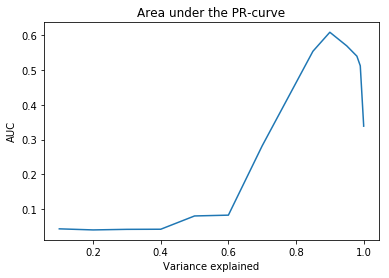

In [13]:
plt.plot(varE, aucs)
plt.title('Area under the PR-curve')
plt.xlabel('Variance explained')
plt.ylabel('AUC');

/Users/bmyara/miniconda/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


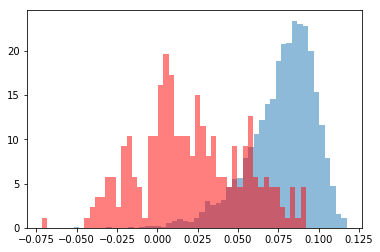

In [22]:
plt.hist(y_pred_test[:nnominal], bins=50, normed=True, alpha=.5);
plt.hist(y_pred_test[nnominal:], bins=50, color='red', normed=True, alpha=.5);

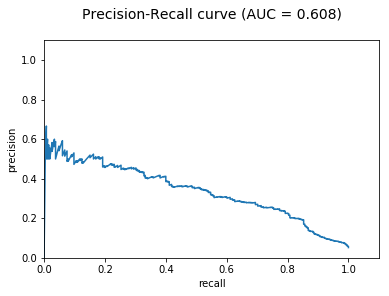

In [23]:
plot_pr(p, r, auc)

## 2. Local Outlier Factor

In [121]:
from sklearn.neighbors import LocalOutlierFactor

In [25]:
pca = decomposition.PCA(.8)
X_pca = pca.fit_transform(X_train)
Xt_pca = pca.transform(X_test)

In [29]:
lof = LocalOutlierFactor(contamination=0.001)
lof.fit(X_pca)
X_lof = lof._decision_function(Xt_pca)

/Users/bmyara/miniconda/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


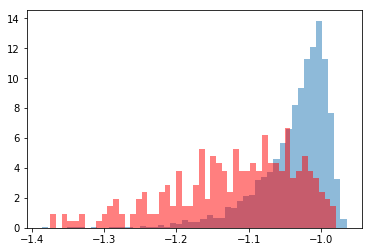

In [30]:
plt.hist(X_lof[:nnominal], bins=50, alpha=.5, normed=True);
plt.hist(X_lof[nnominal:], bins=50, color='red', alpha=.5, normed=True);

In [32]:
varE = [.1, .2, .3, .4, .5, .6, .7, .8, .82, .85, .9, .95, .99, 1.]
aucs = []
ypredtests = []
for v in varE:
    
    # (1) Dimensionality reduction
    print('*' * 20)
    pca = decomposition.PCA(v) if v != 1. else decomposition.PCA()
    X_train_pca = pca.fit_transform(X_train)
    print(' explained variance = %.2f - n components = %i' % (v, pca.n_components_))
    
    # Isolation Forest
    localOut = LocalOutlierFactor(contamination=.001)
    localOut.fit(X_train_pca)
    X_test_pca = pca.transform(X_test)
    y_pred_test = localOut._decision_function(X_test_pca)
    ypredtests.append(y_pred_test)
    
    scores = y_pred_test
    labels = Y_test

    p, r, t, auc = calc_pr(scores, labels)
    aucs.append(auc)
    print('AUC = %.3f' % auc)
    
y_pred_test = ypredtests[np.argmax(aucs)]
auc = aucs[np.argmax(aucs)]

********************
 explained variance = 0.10 - n components = 1
AUC = 0.053
********************
 explained variance = 0.20 - n components = 2
AUC = 0.044
********************
 explained variance = 0.30 - n components = 4
AUC = 0.058
********************
 explained variance = 0.40 - n components = 6
AUC = 0.078
********************
 explained variance = 0.50 - n components = 9
AUC = 0.108
********************
 explained variance = 0.60 - n components = 13
AUC = 0.165
********************
 explained variance = 0.70 - n components = 22
AUC = 0.190
********************
 explained variance = 0.80 - n components = 37
AUC = 0.298
********************
 explained variance = 0.82 - n components = 43
AUC = 0.314
********************
 explained variance = 0.85 - n components = 52
AUC = 0.371
********************
 explained variance = 0.90 - n components = 79
AUC = 0.436
********************
 explained variance = 0.95 - n components = 139
AUC = 0.474
********************
 explained variance = 0

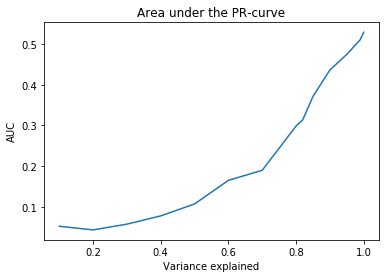

In [33]:
plt.plot(varE, aucs)
plt.title('Area under the PR-curve')
plt.xlabel('Variance explained')
plt.ylabel('AUC');

/Users/bmyara/miniconda/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


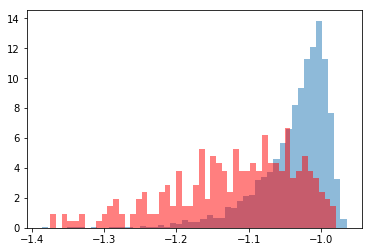

In [34]:
# plt.hist(y_pred_test, bins=50, normed=True, alpha=.5);
# plt.hist(y_pred_anomalies, bins=50, color='red', normed=True, alpha=.5);
plt.hist(X_lof[:nnominal], bins=50, alpha=.5, normed=True);
plt.hist(X_lof[nnominal:], bins=50, color='red', alpha=.5, normed=True);

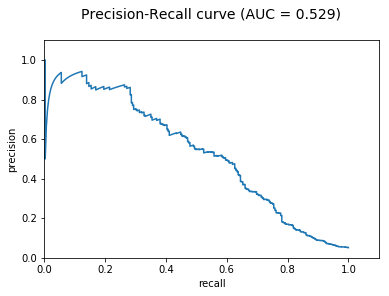

In [35]:
p, r, t, auc = calc_pr(scores, labels, plot=True)

## 3. One-class SVM

In [36]:
from sklearn.svm import OneClassSVM

In [37]:
svm = OneClassSVM()
pca = decomposition.PCA(.5)
X_pca = pca.fit_transform(X_train)
Xt_pca = pca.transform(X_test)
R_pca = pca.transform(X_random)

svm.fit(X_pca)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [38]:
Xt_svm = svm.decision_function(Xt_pca)
R_svm = svm.decision_function(R_pca)

/Users/bmyara/miniconda/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


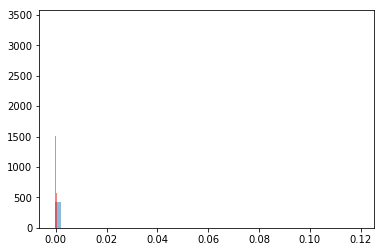

In [40]:
normed = True
plt.hist(Xt_svm[:nnominal], bins=50, normed=normed, alpha=.5);
plt.hist(Xt_svm[nnominal:], bins=50, normed=normed, color='red', alpha=.5);

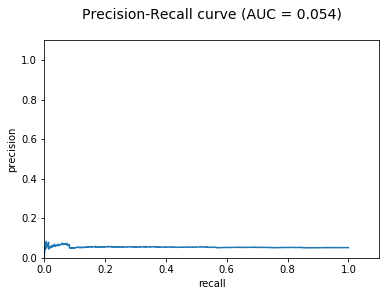

In [41]:
scores = Xt_svm[:, 0]
labels = Y_test
p, r, t, auc = calc_pr(scores, labels)
plot_pr(p, r, auc)

In [42]:
varE = [.1, .2, .3, .4, .5, .6, .7, .8, .85, .9, .95, .99, 1.]
aucs = []
ypredtests = []
for v in varE:
    
    # (1) Dimensionality reduction
    print('*' * 20)
    pca = decomposition.PCA(v) if v != 1. else decomposition.PCA()
    X_train_pca = pca.fit_transform(X_train)
    print(' explained variance = %.2f - n components = %i' % (v, pca.n_components_))
    #X_train_pca = pca.transform(X_train)
    
    # Isolation Forest
    svm = OneClassSVM(nu=.01)
    svm.fit(X_train_pca)
    X_test_pca = pca.transform(X_test)

    y_pred_test = svm.decision_function(X_test_pca)
    ypredtests.append(y_pred_test)
    scores = y_pred_test[:, 0]
    labels = Y_test

    p, r, t, auc = calc_pr(scores, labels)
    aucs.append(auc)
    print('AUC = %.3f' % auc)

y_pred_test = ypredtests[np.argmax(aucs)]
auc = aucs[np.argmax(aucs)]

********************
 explained variance = 0.10 - n components = 1
AUC = 0.049
********************
 explained variance = 0.20 - n components = 2
AUC = 0.049
********************
 explained variance = 0.30 - n components = 4
AUC = 0.051
********************
 explained variance = 0.40 - n components = 6
AUC = 0.055
********************
 explained variance = 0.50 - n components = 9
AUC = 0.041
********************
 explained variance = 0.60 - n components = 13
AUC = 0.049
********************
 explained variance = 0.70 - n components = 22
AUC = 0.044
********************
 explained variance = 0.80 - n components = 37
AUC = 0.059
********************
 explained variance = 0.85 - n components = 52
AUC = 0.055
********************
 explained variance = 0.90 - n components = 79
AUC = 0.057
********************
 explained variance = 0.95 - n components = 139
AUC = 0.135
********************
 explained variance = 0.99 - n components = 294
AUC = 0.264
********************
 explained variance = 

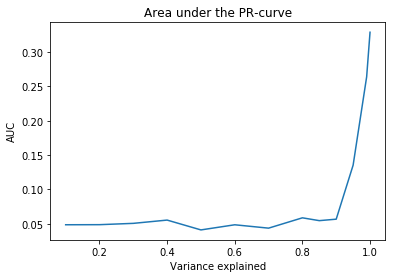

In [43]:
plt.plot(varE, aucs)
plt.title('Area under the PR-curve')
plt.xlabel('Variance explained')
plt.ylabel('AUC');

/Users/bmyara/miniconda/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


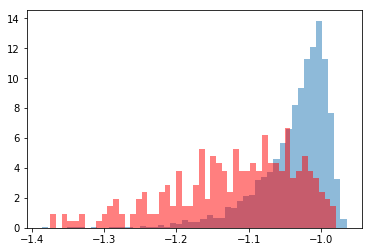

In [44]:
plt.hist(X_lof[:nnominal], bins=50, alpha=.5, normed=True);
plt.hist(X_lof[nnominal:], bins=50, color='red', alpha=.5, normed=True);

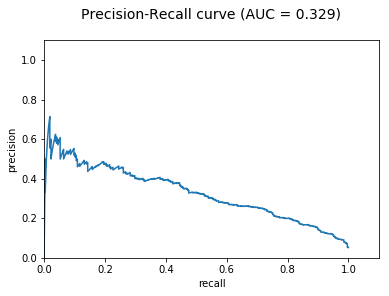

In [45]:
p, r, t, auc = calc_pr(scores, labels, plot=True)

## 4. Autoencoder

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim
from utils import progress, count_parameters, visualize, get_batch

cuda = torch.cuda.is_available() # True if cuda is available, False otherwise
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
print('Training on %s' % ('GPU' if cuda else 'CPU'))

Training on CPU


In [7]:
X_train_ae = (X_train * std + mu) / 255.
X_test_ae = X_train_ae

In [8]:
def tonumpy(x):
    return x.data.cpu().numpy()


# def evaluate(net, data, shape, norm='fro'):
#     shape = tuple([-1] + shape)
#     output = []
#     for j, x in enumerate(get_batch(data, batch_size, allow_smaller_batch=True)):
#         x_ = Variable(torch.from_numpy(x).type(FloatTensor))
#         x_ = x_.view(shape)
#         x_tilda = net(x_).data.cpu().numpy().reshape((-1, np.prod(shape[1:])))
#         output.append(np.linalg.norm(x.reshape(-1, np.prod(shape[1:])) - x_tilda, axis=1, ord=norm))
#     return np.concatenate(output)

def l1norm(data, net):
    x = Variable(torch.from_numpy(data).type(FloatTensor))
    x_tilda = net(x).cpu().data.numpy()
    x = x.cpu().data.numpy()
    return np.sum(np.abs((x - x_tilda)), axis=1)

In [99]:
n_dim = 28*28
z = 49
net2 = nn.Sequential(
                # Encoder
                nn.Linear(n_dim, 196),
                nn.ReLU(),
                nn.Linear(196, z),
                nn.ReLU(),

                # Decoder
                nn.Linear(z, 196),
                nn.ReLU(),
                nn.Linear(196, n_dim)).type(FloatTensor)

count_parameters(net2)
optimizer = torch.optim.Adamax(params=net2.parameters(), lr=0.01)

327,761 parameters
327,761 trainable parameters


In [488]:
# z = 1 # default=8
# net2  = nn.Sequential(
#                 # Encoder
#                 nn.Conv2d(1, 32, 3, padding=1), # input (1, 28, 28), output (32, 28, 28)
#                 nn.PReLU(32),
#                 nn.BatchNorm2d(32),
#                 nn.MaxPool2d(2), # (32, 14, 14)
#                 nn.Conv2d(32, 64, 3), # (64, 12, 12)
#                 nn.PReLU(64),
#                 nn.BatchNorm2d(64),
#                 nn.MaxPool2d(2), # (64, 6, 6))
                
#                 # Low-dimensional representation
#                 nn.Conv2d(64, z, 3), # (8, 4, 4) -- latent representation
#                 nn.PReLU(z),
#                 nn.BatchNorm2d(z),
                
#                 # Decoder
#                 nn.Conv2d(z, 64, 3, padding=2), # (64, 6, 6)
#                 nn.Upsample(scale_factor=2), # (64, 12, 12)
#                 nn.Conv2d(64, 32, 3, padding=2), # (32, 14, 14)
#                 nn.PReLU(32),
#                 nn.Upsample(scale_factor=2), # (32, 28, 28)
#                 nn.Conv2d(32, 1, 3, padding=1),
#                 nn.Sigmoid()).type(FloatTensor).type(FloatTensor)
# count_parameters(net2)
# optimizer = torch.optim.Adam(params=net2.parameters(), lr=0.01)

In [100]:
max_epochs = 30
batch_size = 32
N = X_train.shape[0]
ypredtests = []
aucs = []
for i in range(max_epochs):
    loss_agg = []
    start = time.time()
    net2.train()
    for j, x in enumerate(get_batch(X_train_ae, batch_size, allow_smaller_batch=True)):
        x = Variable(torch.from_numpy(x).type(FloatTensor))
        x = x.view(x.size(0), -1)
        #x = x.view((-1, 1, 28, 28))
        net2.zero_grad()
        x_ = net2(x)
        loss = torch.dist(x, x_) 
        loss.backward()
        optimizer.step()
        loss_agg.append(loss.data.cpu().numpy())
        progress(loss_agg, i + 1, max_epochs, j + 1, batch_size, N, start, net2, mnist.data[:55000], in_size=[28*28])
    else:
        if i % 20 == 0 and i != 0:
            optimizer.param_groups[0]['lr'] /= 2.
            
        net2.eval()
        y_pred_test = l1norm(X_test_ae, net2)
        mean_normal = np.mean(y_pred_test[:nnominal])
        mean_anomaly = np.mean(y_pred_test[nnominal:])

        scores = -y_pred_test
        labels = Y_test

        p, r, t, auc = calc_pr(scores, labels)
        aucs.append(auc)
        ypredtests.append(y_pred_test)
        print('\x1b[31m%.3f - auc = %.3f\x1b[0m' % (mean_anomaly / mean_normal, auc))
        
y_pred_test = ypredtests[np.argmax(aucs)]
auc = aucs[np.argmax(aucs)]

[ 1/30][==================================================] 100% – loss 29.61706 -    1s [3076 fps]
1.487 - auc = 0.532
[ 2/30][==================================================] 100% – loss 23.43742 -    1s [3313 fps]
1.571 - auc = 0.622
[ 3/30][==================================================] 100% – loss 21.81891 -    1s [3057 fps]
1.565 - auc = 0.617
[ 4/30][==================================================] 100% – loss 21.04042 -    1s [2891 fps]
1.581 - auc = 0.618
[ 5/30][==================================================] 100% – loss 20.54423 -    2s [1736 fps]
1.584 - auc = 0.602
[ 6/30][==================================================] 100% – loss 20.19492 -    3s [1354 fps]
1.601 - auc = 0.628
[ 7/30][==================================================] 100% – loss 19.90536 -    3s [1413 fps]
1.600 - auc = 0.622
[ 8/30][==================================================] 100% – loss 19.74207 -    3s [1487 fps]
1.602 - auc = 0.621
[ 9/30][================================

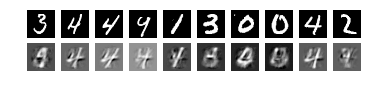

In [14]:
net2.eval()
visualize(net2, X_test[nnominal - 200:], in_size=[28*28], dtype=FloatTensor)

In [101]:
# shape = [1, 28, 28]
shape = [n_dim]
norm = None
net2.eval()
#y_pred_test = l1norm(X_test_ae, net2)
y_pred_test = ypredtests[np.argmax(aucs)]
y_pred_rand = l1norm(X_random, net2)


mean_normal = np.mean(y_pred_test[:nnominal])
mean_anomaly = np.mean(y_pred_test[nnominal:])
mean_random = np.mean(y_pred_rand)

# mean_anomaly = np.mean(y_pred_anomalies)
print('mean normal: %.3f\nmean anomaly: %.3f\nmean random: %.3f\nratio: %.3f' % (mean_normal, mean_anomaly, mean_random, mean_anomaly / mean_normal))

mean normal: 41.388
mean anomaly: 68.403
mean random: 336.478
ratio: 1.653


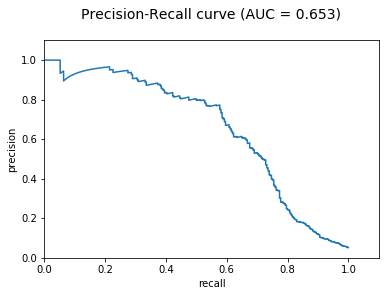

In [102]:
scores = -y_pred_test
labels = Y_test
p, r, t, auc = calc_pr(scores, labels, plot=True)

/Users/bmyara/miniconda3/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


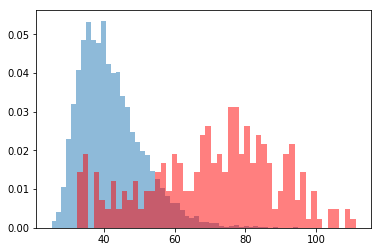

In [17]:
plt.hist(y_pred_test[:nnominal], bins=50, normed=True, alpha=.5);
plt.hist(y_pred_test[nnominal:], bins=50, color='red', normed=True, alpha=.5);

Denoising Autoencoder.

In [64]:
n_dim = 28*28
z = 49
net2 = nn.Sequential(
                # Encoder
                nn.Linear(n_dim, 196),
                nn.ReLU(),
                #nn.BatchNorm1d(196),
                nn.Linear(196, z),
                nn.ReLU(),
                nn.BatchNorm1d(z),

                # Decoder
                nn.Linear(z, 196),
                nn.ReLU(),
                nn.BatchNorm1d(196),
                nn.Linear(196, n_dim)).type(FloatTensor)

count_parameters(net2)
optimizer = torch.optim.Adamax(params=net2.parameters(), lr=0.01)

328,251 parameters
328,251 trainable parameters


In [65]:
max_epochs = 20
batch_size = 32
N = X_train.shape[0]
ypredtests = []
aucs = []
noise = .2
for i in range(max_epochs):
    loss_agg = []
    start = time.time()
    net2.train()
    for j, x in enumerate(get_batch(X_train_ae, batch_size, allow_smaller_batch=True)):
        x = torch.from_numpy(x).type(FloatTensor)
        x = x.view(x.size(0), -1)
        x_p = (x + torch.rand(x.size()) * noise * 2. - noise)
#         x_p = x
        x_p = Variable(x_p)
        #x = x.view((-1, 1, 28, 28))
        net2.zero_grad()
        x_ = net2(x_p)
        loss = torch.dist(Variable(x), x_) 
        loss.backward()
        optimizer.step()
        loss_agg.append(loss.data.cpu().numpy())
        progress(loss_agg, i + 1, max_epochs, j + 1, batch_size, N, start, net2, mnist.data[:55000], in_size=[28*28])
    else:
        if i % 20 == 0 and i != 0:
            optimizer.param_groups[0]['lr'] /= 2.
            
        net2.eval()
        y_pred_test = l1norm(X_test_ae, net2)
        mean_normal = np.mean(y_pred_test[:nnominal])
        mean_anomaly = np.mean(y_pred_test[nnominal:])

        scores = -y_pred_test
        labels = Y_test

        p, r, t, auc = calc_pr(scores, labels)
        aucs.append(auc)
        ypredtests.append(y_pred_test)
        print('\x1b[31m%.3f - auc = %.3f\x1b[0m' % (mean_anomaly / mean_normal, auc))
        
y_pred_test = ypredtests[np.argmax(aucs)]
auc = aucs[np.argmax(aucs)]

[ 1/20][==================================================] 100% – loss 29.07031 -    2s [2538 fps]
1.467 - auc = 0.581
[ 2/20][==================================================] 100% – loss 23.20547 -    2s [2321 fps]
1.553 - auc = 0.621
[ 3/20][==================================================] 100% – loss 21.61003 -    2s [2504 fps]
1.526 - auc = 0.558
[ 4/20][==================================================] 100% – loss 20.80606 -    2s [2373 fps]
1.587 - auc = 0.621
[ 5/20][==================================================] 100% – loss 20.27963 -    2s [2244 fps]
1.563 - auc = 0.608
[ 6/20][==================================================] 100% – loss 19.95747 -    2s [2073 fps]
1.610 - auc = 0.635
[ 7/20][==================================================] 100% – loss 19.66057 -    2s [2184 fps]
1.868 - auc = 0.638
[ 8/20][==================================================] 100% – loss 19.45813 -    2s [2191 fps]
1.608 - auc = 0.568
[ 9/20][================================

In [94]:
# class Autoencoder(nn.Module):
#     def __init__(self, input_size, dim1, dim2):
#         super(Autoencoder, self).__init__()
#         self.input_size = input_size
#         self.dim1 = dim1
#         self.dim2 = dim2
#         self.layer1 = nn.Parameter(-.6 * torch.rand(self.input_size, self.dim1) + .3)
#         self.layer2 = nn.Parameter(-.2 * torch.rand(self.dim1, self.dim2) + .1)
        
#     def forward(self, input):
#         x = input.view(-1, self.input_size)
#         # encoder
#         x = nn.functional.relu((torch.mm(x, self.layer1)))
#         x = nn.functional.relu((torch.mm(x, self.layer2)))
        
#         # tied decoder
#         x = nn.functional.relu(torch.mm(x, torch.transpose(self.layer2, 0, 1)))
#         x = torch.mm(x, torch.transpose(self.layer1, 0, 1))
#         return x.view_as(input)
    
    
    
class Autoencoder(nn.Module):
    def __init__(self, input_size, dim1, dim2, dim3, dim4):
        super(Autoencoder, self).__init__()
        self.input_size = input_size
        self.dim1 = dim1
        self.dim2 = dim2
        self.dim3 = dim3
        self.dim4 = dim4
        self.layer1 = nn.Parameter(-.6 * torch.rand(self.input_size, self.dim1) + .3)
        self.layer2 = nn.Parameter(-.2 * torch.rand(self.dim1, self.dim2) + .1)
        self.layer3 = nn.Parameter(-.2 * torch.rand(self.dim2, self.dim3) + .1)
        self.layer4 = nn.Parameter(-.2 * torch.rand(self.dim3, self.dim4) + .1)
        #self.layer3 = nn.Parameter(-.6 * torch.rand(self.dim2, self.dim1) + .3)
        #self.layer4 = nn.Parameter(-.2 * torch.rand(self.dim1, self.input_size) + .1)
        
    def forward(self, input):
        x = input.view(-1, self.input_size)
        # encoder
        x = nn.functional.relu((torch.mm(x, self.layer1)))
        x = nn.functional.relu((torch.mm(x, self.layer2)))
        x = nn.functional.relu((torch.mm(x, self.layer3)))
        x = nn.functional.relu((torch.mm(x, self.layer4)))
        
        # tied decoder
        #x = nn.functional.relu((torch.mm(x, self.layer3)))
        #x = torch.mm(x, self.layer4)
        x = nn.functional.relu(torch.mm(x, torch.transpose(self.layer4, 0, 1)))
        x = nn.functional.relu(torch.mm(x, torch.transpose(self.layer3, 0, 1)))
        x = nn.functional.relu(torch.mm(x, torch.transpose(self.layer2, 0, 1)))
        x = torch.mm(x, torch.transpose(self.layer1, 0, 1))
        return x.view_as(input)
    
    
    
net3 = Autoencoder(28*28, 300, 200, 100, 49)
count_parameters(net3)
optimizer = torch.optim.Adamax(params=net3.parameters(), lr=0.01)

320,100 parameters
320,100 trainable parameters


In [98]:
max_epochs = 20
batch_size = 32
N = X_train.shape[0]
ypredtests = []
aucs = []
noise = .2
for i in range(max_epochs):
    loss_agg = []
    start = time.time()
    net3.train()
    for j, x in enumerate(get_batch(X_train_ae, batch_size, allow_smaller_batch=True)):
        x = torch.from_numpy(x).type(FloatTensor)
        x = x.view(x.size(0), -1)
#         x_p = (x + torch.rand(x.size()) * noise * 2. - noise)
        x_p = x
        x_p = Variable(x_p)
        #x = x.view((-1, 1, 28, 28))
        net3.zero_grad()
        x_ = net3(x_p)
        loss = torch.dist(Variable(x), x_) 
        loss.backward()
        optimizer.step()
        loss_agg.append(loss.data.cpu().numpy())
        progress(loss_agg, i + 1, max_epochs, j + 1, batch_size, N, start, net3, mnist.data[:55000], in_size=[28*28])
    else:
        if i % 20 == 0 and i != 0:
            optimizer.param_groups[0]['lr'] /= 2.
            
        net3.eval()
        y_pred_test = l1norm(X_test_ae, net3)
        mean_normal = np.mean(y_pred_test[:nnominal])
        mean_anomaly = np.mean(y_pred_test[nnominal:])

        scores = -y_pred_test
        labels = Y_test

        p, r, t, auc = calc_pr(scores, labels)
        aucs.append(auc)
        ypredtests.append(y_pred_test)
        print('\x1b[31m%.3f - auc = %.3f\x1b[0m' % (mean_anomaly / mean_normal, auc))
        
y_pred_test = ypredtests[np.argmax(aucs)]
auc = aucs[np.argmax(aucs)]

[ 1/20][==================================================] 100% – loss 17.40336 -    2s [2025 fps]
1.546 - auc = 0.620
[ 2/20][==================================================] 100% – loss 17.36237 -    2s [2073 fps]
1.502 - auc = 0.572
[ 3/20][==================================================] 100% – loss 17.29296 -    2s [1972 fps]
1.544 - auc = 0.624
[ 4/20][==================================================] 100% – loss 17.28862 -    2s [1852 fps]
1.548 - auc = 0.619
[ 5/20][==================================================] 100% – loss 17.26841 -    2s [1911 fps]
1.547 - auc = 0.623
[ 6/20][==================================================] 100% – loss 17.16333 -    2s [1734 fps]
1.554 - auc = 0.585
[ 7/20][==================================================] 100% – loss 17.14669 -    2s [1972 fps]
1.552 - auc = 0.594
[ 8/20][==================================================] 100% – loss 17.10737 -    2s [1959 fps]
1.538 - auc = 0.597
[ 9/20][================================

In [106]:
n_dim = 28*28
z = 49
encoder4 = nn.Sequential(
                # Encoder
                nn.Linear(n_dim, 196),
                nn.ReLU(),
                nn.Linear(196, z))
decoder4 = nn.Sequential(
                nn.ReLU(),
                # Decoder
                nn.Linear(z, 196),
                nn.ReLU(),
                nn.Linear(196, n_dim)).type(FloatTensor)
net4 = nn.Sequential(encoder4, decoder4)

count_parameters(net4)
optimizer = torch.optim.Adamax(params=net4.parameters(), lr=0.01)

327,761 parameters
327,761 trainable parameters


In [107]:
max_epochs = 30
batch_size = 32
N = X_train.shape[0]
ypredtests = []
aucs = []
for i in range(max_epochs):
    loss_agg = []
    start = time.time()
    net4.train()
    for j, x in enumerate(get_batch(X_train_ae, batch_size, allow_smaller_batch=True)):
        x = Variable(torch.from_numpy(x).type(FloatTensor))
        x = x.view(x.size(0), -1)
        #x = x.view((-1, 1, 28, 28))
        net4.zero_grad()
        x_ = net4(x)
        loss = torch.dist(x, x_) 
        loss.backward()
        optimizer.step()
        loss_agg.append(loss.data.cpu().numpy())
        progress(loss_agg, i + 1, max_epochs, j + 1, batch_size, N, start, net4, mnist.data[:55000], in_size=[28*28])
    else:
        if i % 20 == 0 and i != 0:
            optimizer.param_groups[0]['lr'] /= 2.
            
        net4.eval()
        y_pred_test = l1norm(X_test_ae, net4)
        mean_normal = np.mean(y_pred_test[:nnominal])
        mean_anomaly = np.mean(y_pred_test[nnominal:])

        scores = -y_pred_test
        labels = Y_test

        p, r, t, auc = calc_pr(scores, labels)
        aucs.append(auc)
        ypredtests.append(y_pred_test)
        print('\x1b[31m%.3f - auc = %.3f\x1b[0m' % (mean_anomaly / mean_normal, auc))
        
y_pred_test = ypredtests[np.argmax(aucs)]
auc = aucs[np.argmax(aucs)]

[ 1/30][==================================================] 100% – loss 28.63539 -    1s [2768 fps]
1.534 - auc = 0.557
[ 2/30][==================================================] 100% – loss 23.40372 -    1s [3113 fps]
1.574 - auc = 0.601
[ 3/30][==================================================] 100% – loss 22.19711 -    1s [2685 fps]
1.555 - auc = 0.598
[ 4/30][==================================================] 100% – loss 21.48862 -    1s [2717 fps]
1.573 - auc = 0.618
[ 5/30][==================================================] 100% – loss 21.05483 -    3s [1701 fps]
1.586 - auc = 0.622
[ 6/30][==================================================] 100% – loss 20.70160 -    3s [1602 fps]
1.595 - auc = 0.628
[ 7/30][==================================================] 100% – loss 20.40109 -    3s [1702 fps]
1.605 - auc = 0.640
[ 8/30][==================================================] 100% – loss 20.22968 -    3s [1585 fps]
1.588 - auc = 0.627
[ 9/30][================================